In [23]:
import matplotlib.pyplot as plt
import os
height = 8
width = height*1.6
plt.rcParams["figure.figsize"] = (width,height)
import numpy as np
plt.style.use('seaborn-colorblind')
import torch
from torch.distributions import Categorical

# import torch
# from torch.distributions import Categorical

# soft = np.full((10),0.1)
# max_val = Categorical(probs = torch.from_np(soft)).entropy().np()
# print(max_val)

plt.style.use('seaborn-colorblind')

def load(directory,train=False):
    metric_directory = directory+'/metrics/'
    ground_truths = list()
    outputs = list()
    
    if train:
        train_state = 'train-'
    else:
        train_state = ''

    for run in range(0,3):
        ground_truth = np.load(metric_directory+train_state+'ground-truth-run-'+str(run)+'.npy')
        output = np.load(metric_directory+train_state+'raw-softmax-run-'+str(run)+'.npy')
        ground_truths.append(ground_truth)
        outputs.append(output)
        
    ground_truths = np.array(ground_truths)
    outputs = np.array(outputs)
        
    mac_readings = np.load(directory+'/metrics/layerwise_macs.npy')
    
    return ground_truths,outputs,mac_readings

def get_label(directory):
    model = directory.split('/')[2]
    branch_weights = np.load(directory+"/metrics/branch-weights-"+model+".npy")
    string = model + ' ('
    for weight in branch_weights:
        weight = np.round(weight,decimals=3)
        string = string + str(weight) + " : "
    string = string[:-3]+')'
    return(string)

def get_exit_p(exit_readings):
    
    exit_p = np.zeros(4)

    for exit in range(len(exit_p)): 
        exit_p[exit] = np.count_nonzero(exit_readings==exit)
    return(exit_p/len(exit_readings))

def get_MACs_acc(exits, macs, important, layers):
    layerwise_macs = np.take(macs,important)
        
    powers = np.zeros(4)
    powers[0]  = np.sum(np.take(layerwise_macs,layers[0]))
    powers[1]  = np.sum(np.take(layerwise_macs,layers[1]))
    powers[2]  = np.sum(np.take(layerwise_macs,layers[2]))
    powers[3]  = np.sum(layerwise_macs)

    exit_p = get_exit_p(exits)

    avg_powers = np.sum(np.multiply(exit_p,powers))

    return avg_powers, exit_p

def branch_MACs(directory, runs, important, layers):
    model = directory.split('/')[2]
    _,_, macs = load(directory)
    layerwise_macs = np.take(macs,important)
    label = get_label(directory)
    accuracies = np.load(directory+"/metrics/branch-val-accuracies-"+model+".npy")
    mean_accuracies = np.mean(accuracies,axis=0)
    std_accuracies = np.std(accuracies,axis=0)
    
    accs = np.zeros(4)
    std = np.zeros(4)
    for idx,row in enumerate(mean_accuracies):
        branch_best = np.argmax(row)
        accs[idx] = mean_accuracies[idx,branch_best]
        std[idx] = std_accuracies[idx,branch_best]
        
    powers = np.zeros(4)
    powers[0]  = np.sum(np.take(layerwise_macs,layers[0]))
    powers[1]  = np.sum(np.take(layerwise_macs,layers[1]))
    powers[2]  = np.sum(np.take(layerwise_macs,layers[2]))
    powers[3]  = np.sum(layerwise_macs)
    
    return powers, accs, std, label

In [2]:
def get_plot_values(directory,layers,branches,n_thresh=100):

    label = get_label(directory)

    ground_truths, outputs, power = load(directory)

    runs = outputs.shape[0]
    n_branches = outputs.shape[1]
    n_inputs = ground_truths.shape[1]

    n_classes = outputs.shape[3]
    p = 1.0 /n_classes
    max_entropy = -sum([p * np.log(p) for _ in range(n_classes)])
    print("N Classes: ",n_classes,"\tMax Entropy:",max_entropy)

    thresholds = np.linspace(max_entropy,0,n_thresh)
    accuracies = np.zeros((2,n_thresh))
    MACs = np.zeros((2,n_thresh))
    percentages = np.zeros((n_thresh,n_branches))
    branch_accs = np.zeros((runs,n_branches,n_inputs))
    branch_exits = np.full((n_thresh,runs,n_inputs),n_branches-1)

    for thresh_idx,threshold in enumerate(thresholds):
        thresh_acc = np.zeros(runs)
        thresh_mac = np.zeros(runs)
        thresh_p = np.zeros((runs,n_branches))
        for run in range(runs):
            run_output = outputs[run,:,:,:]
            branch_predictions = np.argmax(run_output,axis=2)
            branch_accs[run,:,:] = (branch_predictions==ground_truths[0,:])

            entropy = Categorical(probs = torch.from_numpy(run_output)).entropy().numpy()
            N = entropy.shape[1]

            exits = np.full(N,3)
            predictions = np.argmax(run_output[-1,:,:],1)

            for inp_idx, _ in enumerate(ground_truths[0]):
                entropies = entropy[:,inp_idx]
                for branch_idx, branch_entr in enumerate(entropies):
                    if branch_entr < threshold:
                        exits[inp_idx] = branch_idx
                        predictions[inp_idx] = np.argmax(run_output[branch_idx,inp_idx,:])
                        branch_exits[thresh_idx,run,inp_idx] = branch_idx
                        break

            thresh_acc[run] = np.sum(np.equal(ground_truths[run],predictions))/N
            thresh_mac[run], thresh_p[run,:] = get_MACs_acc(exits, power, layers, branches)

        accuracies[0,thresh_idx] = np.mean(thresh_acc)
        accuracies[1,thresh_idx] = np.std(thresh_acc)
        MACs[0,thresh_idx] = np.mean(thresh_mac)
        MACs[1,thresh_idx] = np.std(thresh_mac)

        percentages[thresh_idx,:] = np.mean(thresh_p,axis=0)
    return(accuracies,MACs,percentages,thresholds,label,branch_accs,branch_exits)


def plot_branch_accuracy(branch_accs,exits,thresholds):
    branch_accuracies = np.zeros((branch_accs.shape[0],branch_accs.shape[1],thresholds.shape[0]))
    print(branch_accuracies.shape)
    for run in range(0,branch_accuracies.shape[0]):
        for thresh_idx, _ in enumerate(thresholds):
            for branch in range(0,4):
                exit_idx = np.argwhere(exits[thresh_idx,run,:] == branch)
                branch_accuracies[run,branch,thresh_idx] = np.sum(branch_accs[run,branch,exit_idx])/exit_idx.shape[0]

    mean_accuracies = np.mean(branch_accuracies,axis=0)
    std_accuracies = np.std(branch_accuracies,axis=0)
    return(mean_accuracies,std_accuracies)



In [15]:
#testing with single directory

mobilenet_layers = [2,6,10,16,20,36,48,61,79,98,117,135,154,172,191,210,214,218]
mobilenet_branches = [[0,3,4,5],[0,1,3,4,5,6,7,8],[0,1,2,3,4,6,7,8,9,10,11,12]]

resnet_layers = [1,2,3,16,31,46,61,62,63,64]
resnet_branches = [[0,1,2,6],[0,1,2,3,6,7],[0,1,2,3,4,6,7,8]]

directory = "../trained-models/BranchedResNet18/CIFAR100/wb102-b202-b302/"

accuracies,MACs,percentages,thresholds,label,branch_accs,exits = get_plot_values(directory,resnet_layers,resnet_branches)

N Classes:  100 	Max Entropy: 4.605170185988082


(3, 4, 100)


/Users/jackdymond/Documents/Work/PhD/Experiments/Class Separation/Code/Class-Separation/environment/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars


[0.60954195 0.70472755 0.72409187 0.7265291 ]


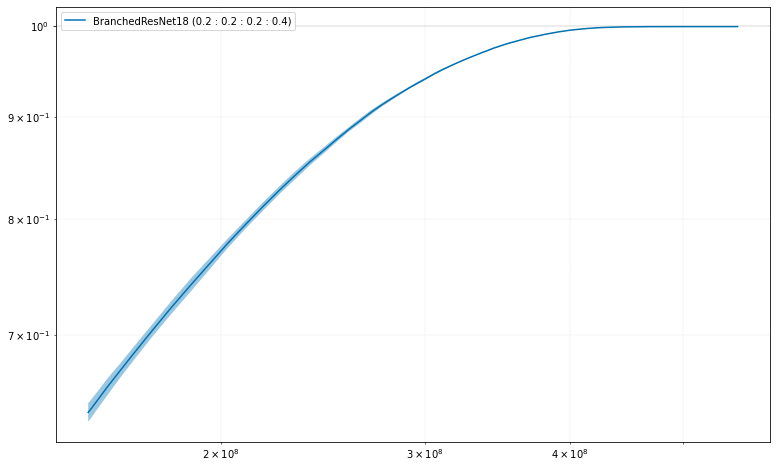

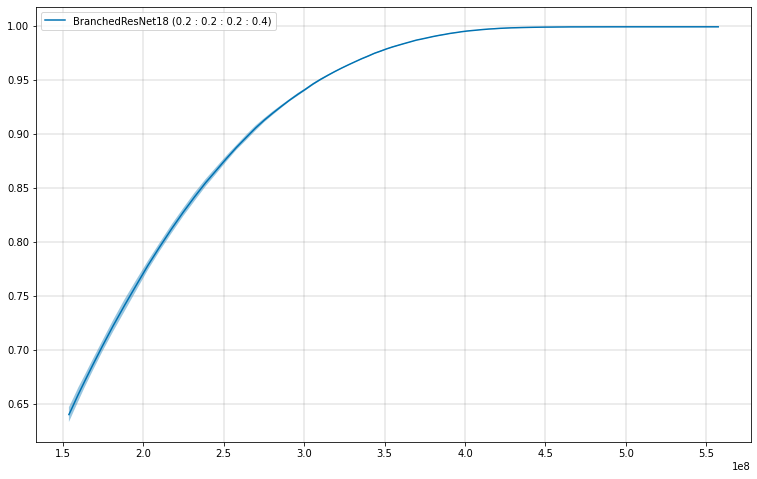

In [16]:
#plotting test results
mean_accuracies, _ = plot_branch_accuracy(branch_accs,exits,thresholds)
power,branch_base_accs,branch_base_std,label = branch_MACs(directory,3,resnet_layers,resnet_branches)

print(branch_base_accs)

plt.plot(MACs[0],accuracies[0],label=label)
plt.fill_between(MACs[0],accuracies[0]+accuracies[1],accuracies[0]-accuracies[1],alpha=0.4)
plt.xscale('log')
plt.yscale('log')
plt.grid(color='grey', linestyle='-', linewidth=0.3)
plt.grid(which='minor',color='lightgrey', linestyle='--', linewidth=0.3)
plt.legend()
plt.show()

plt.plot(MACs[0],accuracies[0],label=label)
plt.fill_between(MACs[0],accuracies[0]+accuracies[1],accuracies[0]-accuracies[1],alpha=0.4)
# plt.xscale('log')
# plt.yscale('log')
plt.grid(color='grey', linestyle='-', linewidth=0.3)
plt.grid(which='minor',color='lightgrey', linestyle='--', linewidth=0.3)
plt.legend()
plt.show()


In [78]:
# directory = "../trained-models/BranchedMobileNet/CIFAR10/CA-ls-wb102-b202-b302/"

# smooth_ground_truths, smooth_outputs, _ = load(directory,train=True)
# # test_ground_truths, test_outputs,_  =  load(directory)

directory = "../trained-models/BranchedResNet18/CIFAR100/wb102-b202-b302/"

ground_truths, outputs, _ = load(directory,train=True)
# test_ground_truths, test_outputs,_  =  load(directory)

In [79]:

run = 0 

chosen = outputs[run,:]
one_hot = np.zeros_like(chosen)
predictions = np.argmax(outputs[run,:],axis=-1)

for branch in range(chosen.shape[0]):
    for input in range(chosen.shape[1]):
        if predictions[branch,input] == predictions[-1,input]:
            one_hot[branch,input,predictions[branch,input]] = 1

totals = np.sum(one_hot,axis=1)
match_per = totals/totals[-1,:]


(4, 50000, 100)
1.0
(4, 50000)
(50000,)

branch:  0
match percentage:  0.642
accuracy:  0.642

branch:  1
match percentage:  0.82718
accuracy:  0.82718

branch:  2
match percentage:  0.99792
accuracy:  0.99792


In [ ]:

summed = np.sum(one_hot)
labels = ground_truths[run,:]
print(np.max(one_hot))

print(predictions.shape)
print(labels.shape)

final_predictions = predictions[-1,:]

for branch in range(predictions.shape[0]-1):
    print('\nbranch: ',branch)
    matches = predictions[branch,:]==labels
    print('match percentage: ',sum(matches)/final_predictions.shape[-1])
    correct = predictions[branch,:]==labels
    print('accuracy: ', sum(correct)/final_predictions.shape[-1])



In [5]:
from scipy import optimize

def test_func(x, a, b):
    return a*(x**b)

params, params_covariance = optimize.curve_fit(test_func, MACs[0], accuracies[0],
                                               p0=[2, 2])

print(params)

[1.47921361e-15 2.00000000e+00]


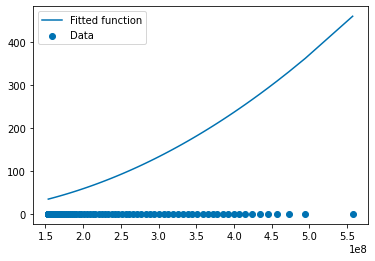

In [6]:
plt.figure(figsize=(6, 4))
plt.scatter(MACs[0], accuracies[0], label='Data')
plt.plot(MACs[0], test_func(MACs[0], params[0], params[1]),
         label='Fitted function')

plt.legend(loc='best')

plt.show()

/Users/jackdymond/Documents/Work/PhD/Experiments/Class Separation/Code/Class-Separation/environment/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


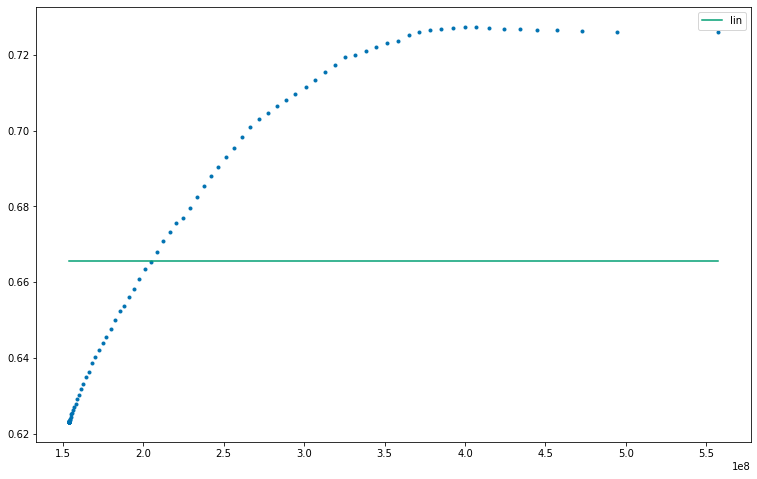

In [7]:
from scipy import optimize

x = MACs[0]
y = accuracies[0]

x_min = np.min(x)
x_max = np.max(x)

def piecewise_power(x, x0, a, b, k1, k2):
    condlist = [x < x0, x >= x0]
    funclist = [lambda x: x**k1 + a, lambda x: x**k2 + b + a]
    return np.piecewise(x, condlist, funclist)

def piecewise_lin(x, x0, a, b, k1):
    condlist = [x < x0, x >= x0]
    funclist = [lambda x: k1*x + a, lambda x: b]
    return np.piecewise(x, condlist, funclist)

def piecewise_log(x, x0, k1, k2, k3, k4):
    condlist = [x < x0, x >= x0]
    funclist = [lambda x: k1*np.log(x) + k3, lambda x: k4]
    return np.piecewise(x, condlist, funclist)

p0 = [16.0,1.0,1.0,1.0]  
p , e = optimize.curve_fit(piecewise_lin, x, y, p0)

xd = np.linspace(x_min, x_max, 1000)
plt.plot(x, y, ".")
plt.plot(xd, piecewise_lin(xd, *p),label='lin')

# p0 = np.array([1.0,1.0,1.0,1.0,0.1])  
# p , e = optimize.curve_fit(piecewise_power, x, y, p0)
# plt.plot(xd,piecewise_power(xd,*p),label='power-power')

# p0 = np.array([1,1.0,1.0,1.0,0.1])  
# p , e = optimize.curve_fit(piecewise_log, x, y, p0)
# plt.plot(xd,piecewise_log(xd,*p),label='log-lin')

plt.legend()

plt.show()

(100,)


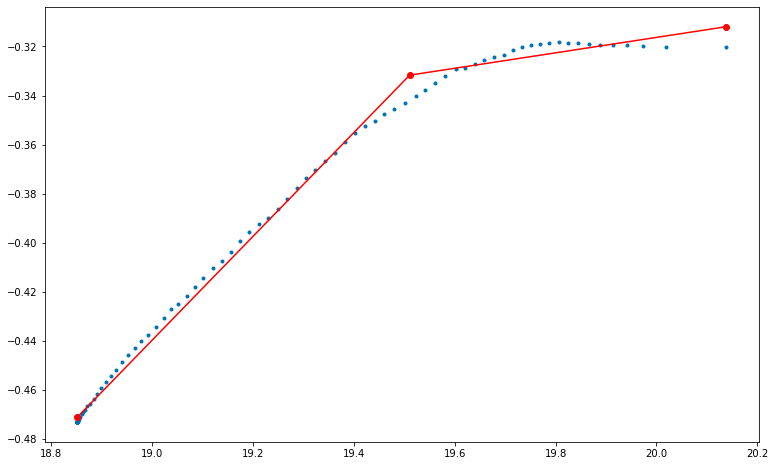

In [8]:
def segments_fit(X, Y, count):
    xmin = X.min()
    xmax = X.max()

    seg = np.full(count - 1, (xmax - xmin) / count)

    px_init = np.r_[np.r_[xmin, seg].cumsum(), xmax]
    py_init = np.array([Y[np.abs(X - x) < (xmax - xmin) * 0.01].mean() for x in px_init])

    def func(p):
        seg = p[:count - 1]
        py = p[count - 1:]
        px = np.r_[np.r_[xmin, seg].cumsum(), xmax]
        return px, py

    def err(p):
        px, py = func(p)
        Y2 = np.interp(X, px, py)
        return np.mean((Y - Y2)**2)

    r = optimize.minimize(err, x0=np.r_[seg, py_init], method='Nelder-Mead', options={'maxiter':10000})
    return func(r.x)

px, py = segments_fit(np.log(x), np.log(y), 2)

plt.plot(np.log(x), np.log(y), ".")
plt.plot(px, py, "-or");
print(x.shape)

params guessed  : (0.1, 0.1, 0.1, 0.1, 0.1)
params from fit : [ 1.21981778e-36  1.32670430e-27 -3.59300853e-18  1.96093573e-09
  4.01385902e-01]


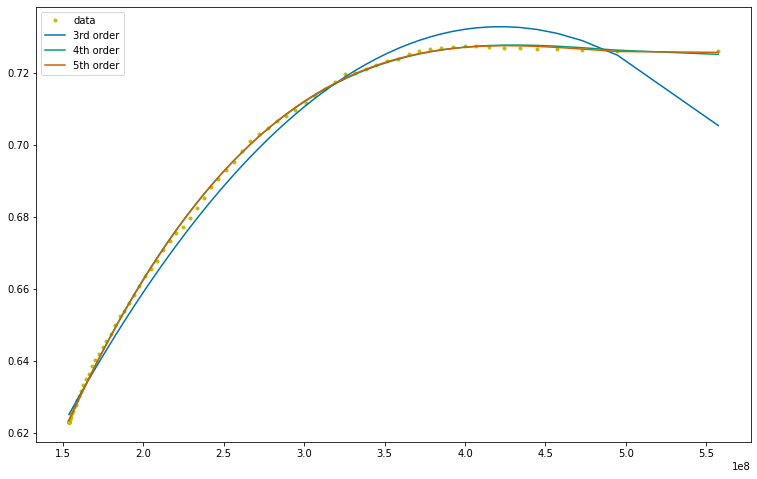

In [9]:
def polyfit(x, *p):
    ''' function to fit the indentation curve 
    p = [x0,c, poly1d_coeffs ]'''
    x = x.astype(float)
    # y =  (p[1]*x + p[2])*(1-sigmoid(x-p[0],k=1)) + p[3]*x*(sigmoid(x-p[0],k=1))
    # y = (p[0]*x + p[1])*(1-sigmoid(x-p[2],k=1)) + (p[3]*x + p[4])*(sigmoid(x-p[2],k=1))
    # y = np.poly1d(p[2:])(x)*(1-sigmoid(x-p[0],k=1)) + p[1]*(sigmoid(x-p[0],k=1)) 
    y = np.poly1d(p[:])(x)  
    # y = p[0]*x
    return y

def sigmoid(x, k=1):
    return 1/(1+np.exp(-k*x))

p0_guess = (0.1,0.1,0.1,0.1,0.1)
popt, pcov = optimize.curve_fit(polyfit, x, y, p0=p0_guess)
print('params guessed  : '+str(p0_guess))
print('params from fit : '+str(popt))

p3_guess = (0.1,0.1,0.1)
three_popt, three_pcov = optimize.curve_fit(polyfit, x, y, p0=p3_guess)

p4_guess = (0.1,0.1,0.1,0.1)
four_popt, four_pcov = optimize.curve_fit(polyfit, x, y, p0=p4_guess)

p5_guess = (0.1,0.1,0.1,0.1,0.1)
five_popt, five_pcov = optimize.curve_fit(polyfit, x, y, p0=p5_guess)


plt.figure(1)
plt.clf()
plt.plot(x,y, 'y.',label='data')
plt.plot(x, polyfit(x, *three_popt), label='3rd order')
plt.plot(x, polyfit(x, *four_popt), label='4th order')
plt.plot(x, polyfit(x, *five_popt), label='5th order')
plt.legend()

[0.20514285531235021, -0.3210020088536887, 19.601531870408344, [18.851355248168463, 20.138820224507494]]


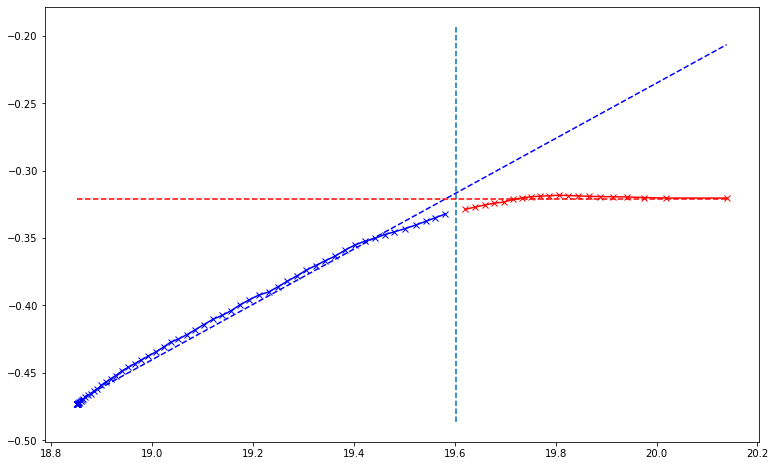

In [10]:
from kneed import KneeLocator

def quantify(MACs, accuracies):

    x = MACs
    y = accuracies

    kn = KneeLocator(x[50:], y[50:], curve='concave', direction='increasing')
    log_kn = np.log(kn.knee)

    x = np.log(x)
    y = np.log(y)

    power_y, power_x = y[x<log_kn], x[x<log_kn]
    power_min = np.min(power_x)
    power_max = np.max(power_x)

    const_y, const_x = y[x>log_kn], x[x>log_kn]
    lin_min = np.min(const_x)
    lin_max = np.max(const_x)

    const = np.mean(const_y)

    def power(x,k1,k2):
        return (k1*x + k2)

    def const(x,k1):
        return x*0 + k1

    power_popt, power_cov = optimize.curve_fit(power, power_x, power_y) 
    const_popt, const_cov = optimize.curve_fit(const, const_x, const_y)

    # print(power_popt,const_popt,log_kn)
    values = [power_popt[0],const_popt[0], log_kn, [x[0],x[-1]]]


    plt.plot(power_x, power_y, 'bx-')
    plt.plot(x, power(x, *power_popt), '--',label='power',color='b')

    plt.plot(const_x, const_y, 'rx-')
    plt.plot(x, const(x, *const_popt), '--', color='r')

    plt.vlines(log_kn, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

    return(values)

values = quantify(MACs[0],accuracies[0])
print(values)

In [11]:
directory = "../trained-models/BranchedMobileNet/CIFAR100/wb102-b202-b302/"
accuracies_m,MACs_m,percentages,thresholds,label,branch_accs,exits = get_plot_values(directory,mobilenet_layers,mobilenet_branches)
directory = "../trained-models/BranchedResNet18/CIFAR100/wb102-b202-b302/"
accuracies_r,MACs_r,percentages,thresholds,label,branch_accs,exits = get_plot_values(directory,resnet_layers,resnet_branches)

N Classes:  100 	Max Entropy: 4.605170185988082
N Classes:  100 	Max Entropy: 4.605170185988082


## Performance:

$$P = \gamma \frac{m\times(1+c)}{4x_{\text{min}}+ (x_{\text{max}} - x_0)} + \eta \frac{c}{x_{\text{max}}}$$

m is the gradient of the 'progressive' element, c is the value of the flat line, $x_{\text{max}}$ is the maximum power, and $x_0$ is the knee point, where the flat line begins. $\gamma$ and $\eta$ are normalisation constants.


In [12]:
# m,c,x0,xm = values[0],values[1],values[2],values[3][1]

def performance(m,c,x0,xm,xl,gamma=8,eta=10):
    prog = gamma*(m*(1+c))/np.log((4*xl+(xm-x0)))
    perf = np.abs(eta*(3*c/xm))
    print(prog,perf)
    return(prog + perf)

[0.16601166713674292, -0.4061271969805338, 16.295808523574397, [14.984795018416087, 16.796607353483285]]
0.1922929458086278 0.7253736217682871
0.9176665675769149
[0.20514285531235021, -0.3210020088536887, 19.601531870408344, [18.851355248168463, 20.138820224507494]]
0.2573528956212799 0.4781839332321747
0.7355368288534545


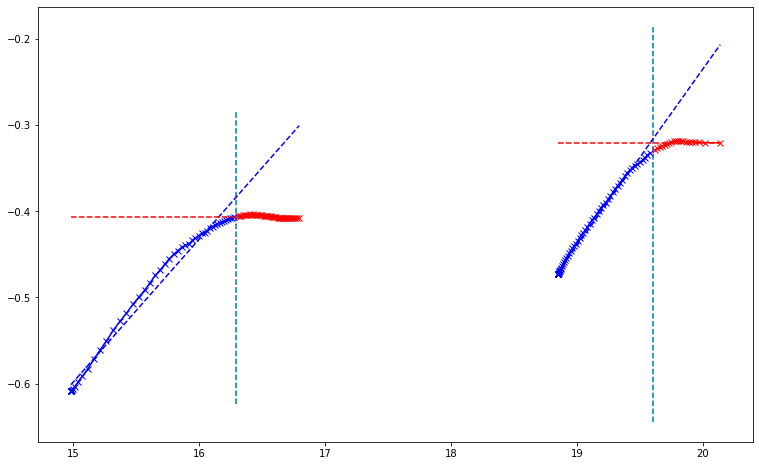

In [13]:
values=list()

value = quantify(MACs_m[0],accuracies_m[0])
print(value)
P = performance(value[0],value[1],value[2],value[3][1],value[3][0])
print(P)
values.append(value)

value = quantify(MACs_r[0],accuracies_r[0])
print(value)
P = performance(value[0],value[1],value[2],value[3][1],value[3][0])
print(P)
values.append(value)
plt.show()
